In [1]:
from collections import OrderedDict
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective

from hnn_core.network_models import L6_model
from optimization import (plot_net_response, plot_spiking_profiles,
                          simulate_network, opt_baseline_spike_rates)

In [2]:
# user parameters

# note that basket cells and pyramidal cells require different amounts of AMPA
# excitatory current in order to drive a spike
poiss_weights_0 = OrderedDict(L2_basket=1e-3, L2_pyramidal=2e-3,
                              L5_basket=1e-3, L5_pyramidal=2e-3,
                              L6_basket=1e-3, L6_pyramidal=2e-3)
# 1 kHz as in Billeh et al. 2020 is too fast for this size of network
# decreasing to 10 Hz seems to allow for random single-cell events in a
# disconnected network
poiss_rate_0 = 1e1

sim_time = 600  # ms
burn_in_time = 200  # ms
n_procs = 10

# log_10 scale
min_weight, max_weight = -5., -1.
# real number scale
min_lamtha, max_lamtha = 1., 100.
min_rate, max_rate = 1., 100.

# opt parameters
opt_n_total_calls = 28
opt_n_init_points = 14

net_original = L6_model(connect_layer_6=True, legacy_mode=False,
                        grid_shape=(10, 10))


In [3]:
# get initial params prior to optimization
#opt_params_0 = get_conn_params(net_original.connectivity)
# poisson drive synaptic weight initial conditions
opt_params_0 = [np.log10(weight) for weight in poiss_weights_0.values()]
# poisson drive rate constant initial conditions
opt_params_0.append(poiss_rate_0)
# poisson drive synaptic weight bounds
opt_params_bounds = np.tile([min_weight, max_weight],
                            (len(poiss_weights_0), 1)).tolist()
# poisson drive rate constant bounds
opt_params_bounds.append([min_rate, max_rate])

In [4]:
# prepare cost function
sim_params = {'sim_time': sim_time, 'burn_in_time': burn_in_time,
              'n_procs': n_procs}
opt_min_func = partial(opt_baseline_spike_rates, net=net_original.copy(),
                       sim_params=sim_params)

# optimize
opt_results = gp_minimize(func=opt_min_func,
                          dimensions=opt_params_bounds,
                          x0=opt_params_0,
                          n_calls=opt_n_total_calls,  # >5**n_params
                          n_initial_points=opt_n_init_points,  # 5**n_params
                          initial_point_generator='lhs',  # sobol; params<40
                          acq_optimizer='sampling',
                          verbose=True,
                          random_state=1234)
opt_params = opt_results.x
print(f'poiss_weights: {[10 ** param for param in opt_params[:-1]]}')
print(f'poiss_rate: {opt_params[-1]}')

Iteration No: 1 started. Evaluating function at provided point.
simulating disconnected network
MPI will run 1 trial(s) sequentially by distributing network neurons over 10 processes.
numprocs=10
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading cu

In [5]:
###############################################################################
# define target spike rates for plotting
# taken from Reyes-Puerta 2015 and De Kock 2007
# see Constantinople and Bruno 2013 for laminar difference in E-cell
# excitability and proportion of connected pairs
target_avg_spike_rates = {'L2_basket': 0.8,
                          'L2_pyramidal': 0.3,
                          'L5_basket': 2.4,  # L5A + L5B avg
                          'L5_pyramidal': 1.4,  # L5A + L5B avg
                          'L6_basket': 1.3,  # estimated; Reyes-Puerta 2015
                          'L6_pyramidal': 0.5}  # from De Kock 2007
# avg rates in unconn network should be a bit less
# try 33% of the avg rates in a fully connected network
target_spike_rates = {cell: rate * 0.33 for cell, rate in
                      target_avg_spike_rates.items()}

simulating disconnected network
MPI will run 1 trial(s) sequentially by distributing network neurons over 6 processes.
numprocs=6
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms..

/home/ryan/anaconda3/envs/hnn_core/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


simulating disconnected network
MPI will run 1 trial(s) sequentially by distributing network neurons over 6 processes.
numprocs=6
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms..

/home/ryan/anaconda3/envs/hnn_core/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/ryan/anaconda3/envs/hnn_core/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/ryan/anaconda3/envs/hnn_core/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/ryan/anaconda3/envs/hnn_core/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/ryan/anaconda3/envs/hn

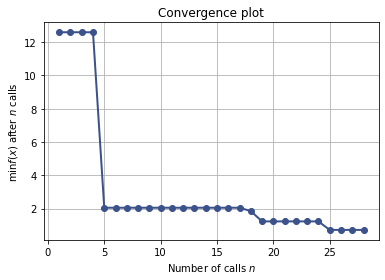

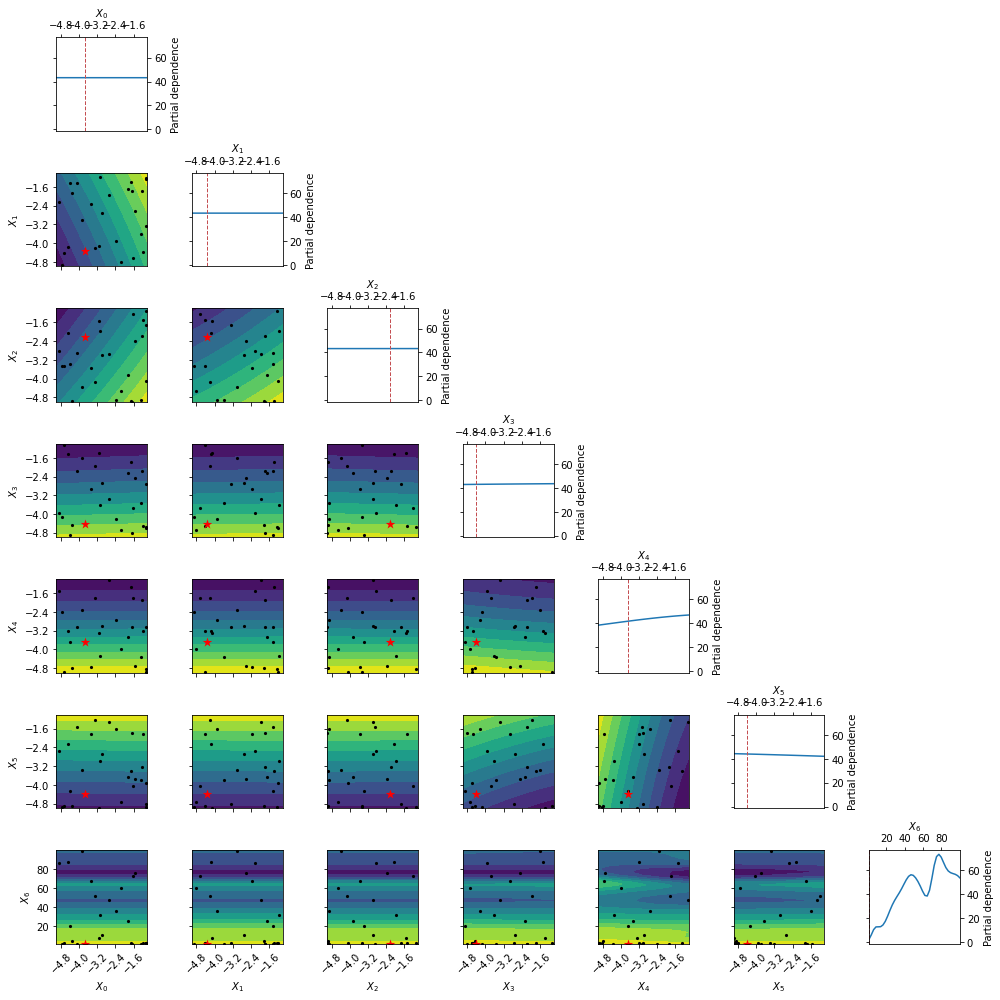

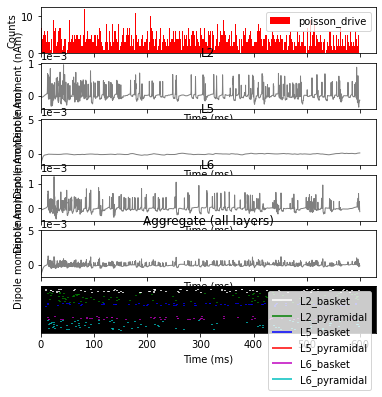

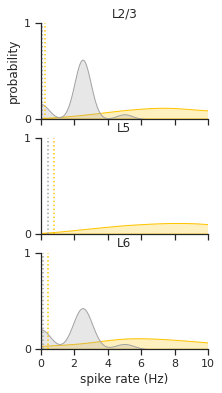

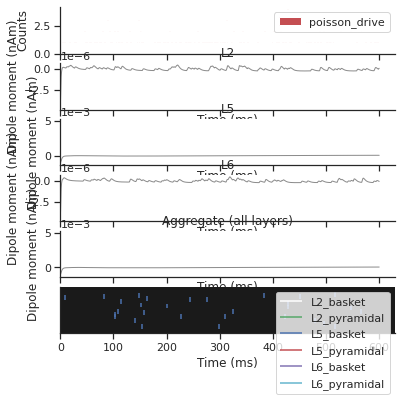

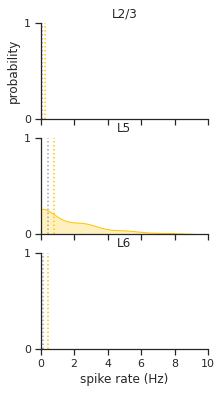

In [7]:
# plot results
plot_convergence(opt_results, ax=None)
ax_obj = plot_objective(opt_results)
ax_obj[0, 0].get_figure().tight_layout()

# pre-optimization
# first convert first param back from log_10 scale
opt_params_init = [10 ** weight for weight in opt_params_0[:-1]]
opt_params_init.append(opt_params_0[-1])
net_0, dpls_0 = simulate_network(net_original.copy(), sim_time, burn_in_time,
                                 poiss_params=opt_params_init, clear_conn=True)
net_response_fig = plot_net_response(dpls_0, net_0, sim_time)
sr_profiles_fig = plot_spiking_profiles(net_0, sim_time, burn_in_time,
                                        target_spike_rates=target_spike_rates)
# post-optimization
opt_params_final = [10 ** weight for weight in opt_params[:-1]]
opt_params_final.append(opt_params[-1])
net, dpls = simulate_network(net_original.copy(), sim_time, burn_in_time,
                             poiss_params=opt_params_final, clear_conn=True)
net_response_fig = plot_net_response(dpls, net, sim_time)
sr_profiles_fig = plot_spiking_profiles(net, sim_time, burn_in_time,
                                        target_spike_rates=target_spike_rates)

plt.show()